# Evolutionary Algorithms (Part 1)

The general scheme of an evolutionary algorithm is as follows:
- We need to decide on some (genetic) _encoding_ for our search problem
- The algorithm acts on a _population_ of individuals, initially usually generated randomly
- From that population a strategy of _parent selection_ decides which individuals may reproduce
- Selection is usually influenced by the _fitness_ of individuals
- _Recombination operators_ describe how parents are recombined, thereby merging genetic material from multiple parents
- As part of recombination, _mutation_ on the offspring may occur
- Which of the parents and offspring represent the next generation is determined by a _survivor selection_ strategy
- There needs to be some criterion to decide on _termination_ of the algorithm (e.g., fixed time or number of fitness evaluations)

Historically, there are different branches of evolutionary computation, and the different flavours of evolutionary algorithms have been associated with different data types to represent solutions. For example, _Genetic Algorithms_ are traditionally associated with binary strings, while _Evolution Strategies_ were mainly concerned with real-valued vectors. These differences are largely irrelevant for our purposes. An overall strategy to derive a suitable evolutionary algorithm or a problem at hand is to:
1. Choose a representation that suits the problem at hand
2. Choose variation operators based on that representation
3. Choose selection operators, which are independent of representation


In [1]:
import matplotlib.pyplot as plt
import random

We will start by considering the one-max problem again, where a solution is a vector of length _n_, consisting of binary numbers.

In [2]:
n = 100

In terms of _genetic encoding_, a _chromosome_ would in this case be the list, each number in the list is a _gene_, and the alleles would be the actual values _0_ and _1_. This _bitstring_ representation also happens to be the classical representation often used for Genetic Algorithms.

In [3]:
def get_random_solution():
    return random.choices([0,1], k=n)

Like all metaheuristics, evolutionary algorithms are guided by a fitness function -- in the case of evolutionary algorithms these mainly inform the selection operators about the fitness of candidate individuals. The fitness function is independent of the metaheuristic search algorithm, but specific to the problem we are attempting to solve, so it is the same fitness function we used for local search algorithms when solving the one max problem:

In [4]:
def get_fitness(solution):
    return sum(solution)

## Evolution Strategies

Evolution Strategies were developed in the 1960s and 1970s by Ingo Rechenberg and Hans-Paul Schwefel. We will start considering canonical evolution strategies which mainly use selection and mutation.

- Ingo Rechenberg (1971): Evolutionsstrategie – Optimierung technischer Systeme nach Prinzipien der biologischen Evolution (PhD thesis). Reprinted by Frommann-Holzboog (1973).
- Hans-Paul Schwefel (1974): Numerische Optimierung von Computer-Modellen (PhD thesis). Reprinted by Birkhäuser (1977).

Classical evolution strategies were applied to real-valued vectors, where mutation was performed by adding a normally distributed random vector. In our one max example, however, we are optimising a bitvector and not a vector of real numbers. We can define a basic mutation as randomly flipping bits in a chromosome (as is the standard way to mutate bitstrings). An important question here is how many bits to flip in a vector: If the changes are too small, this inhibits the exploration aspect of the algorithm; if the changes are too large, this may inhibit exploitation. A common approach is therefore to make a probabilistic number of changes depending on the length of chromosomes used. Given a vector of length _n_, each element is changed with probability _1/n_. On average, one element will thus be changed. However, it may also happen that more or fewer elements are changed.

In [5]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = 1 - copy[position]
    return copy

In [6]:
mutate([0,0,0,0,0,0])

[0, 0, 0, 0, 0, 0]

We need to set some parameters again; first, we'll store the best solution found along the search in the list `fitness_values` again, and we will use the number of fitness evaluations as the stopping condition.

In [7]:
max_steps = 1000
fitness_values = []

To start with, we consider the simplest possible evolution strategy which operates on a population of size two: the current point (parent) and the result of its mutation (offspring). The parent selection is therefore easy -- there is only one parent. Survivor selection chooses the mutant as the next parent if its fitness is at least as good as the parent's fitness, otherwise the parent survives and the mutant is disregarded.

In [8]:
def oneplusone():
    current = get_random_solution()
    fitness = get_fitness(current)
    fitness_values.append(fitness)
    iteration = 1

    while iteration < max_steps:
        iteration += 1
        candidate = mutate(current)
        candidate_fitness = get_fitness(candidate)
        if candidate_fitness >= fitness:
            current = candidate
            fitness = candidate_fitness
        fitness_values.append(fitness)

    return current

As `current` always refers to an individual with the best fitness value encountered so far, we can simply return that and do not need to store a copy of the best individual encountered so far.

In [9]:
fitness_values = []
oneplusone()
opo_values = fitness_values[:]
print(opo_values[-1])

99


To see the progress of the evolution, we can plot the fitness values again:

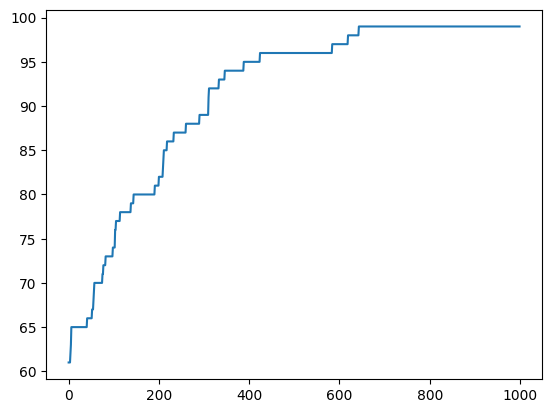

In [10]:
plt.plot(opo_values)

The fitness plot is probably slightly less steep than the one we saw for the hillclimber in the last chapter, or at least somewhat more edged. However, this particular evolutionary algorithm is actually a variant of hillclimbing: It is a _randomised_ (or _stochastic_) hillclimber, where the exploration operator chooses random neighbours. As the mutation operator may change more than one bit, however, we may also be making larger jumps in the search space, rather than just considering immediate neighbours.

The name "one plus one" summarises three different parameters of this evolution strategy. First, the number of offspring may differ from the number of parents. In evolution strategies, the _lambda_ parameter typically denotes how many offspring each parent produces. This generalises the (1+1)-ES to a (1+λ)-ES, where the parent produces λ offspring. The survivor selection then considers the parent as well as all mutants, and picks the best of these as the new parent.

In [11]:
lmbda = 9
def onepluslambda():
    current = get_random_solution()
    best_fitness = get_fitness(current)
    steps = 1
    fitness_values.append(best_fitness)
    while steps < max_steps:
        candidates = [mutate(current) for _ in range(lmbda)]
        candidates.append(current)
        steps += lmbda

        current = max(candidates, key = lambda x: get_fitness(x))
        fitness = get_fitness(current)
        if fitness > best_fitness:
            best_fitness = fitness
            
        fitness_values.extend([best_fitness] * lmbda)

    return current

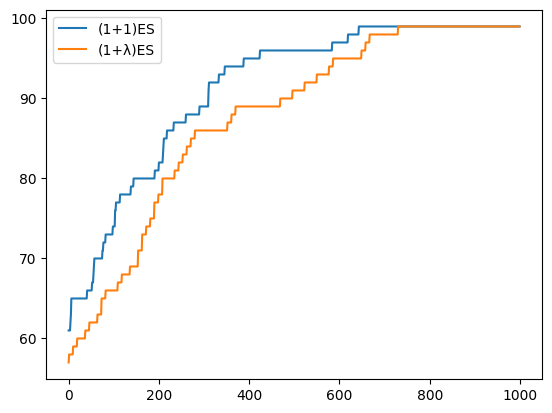

In [12]:
fitness_values = []
onepluslambda()
opl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.legend()

Increasing λ leads to more exploration of the local neighbourhood of the current solution; intuitively, the effects will be similar like switching between steepest ascent and first ascent hillclimbers.

The second parameter is the selection strategy, which in the `onepluslambda` strategy is encoded in the name, `plus`, as it considers the parent _plus_ the offspring during selection. An alternative selection is _comma_-selection, where survivors are only selected from the offspring.

In [13]:
def onecommalambda():
    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    fitness_values.append(best_fitness)
    steps = 1
    while steps < max_steps:
        candidates = [mutate(current) for _ in range(lmbda)]
        steps += lmbda

        current = max(candidates, key = lambda x: get_fitness(x))
        fitness = get_fitness(current)        
        if fitness > best_fitness:
            best_fitness = fitness
            best = current
        fitness_values.extend([best_fitness] * lmbda)

    return best

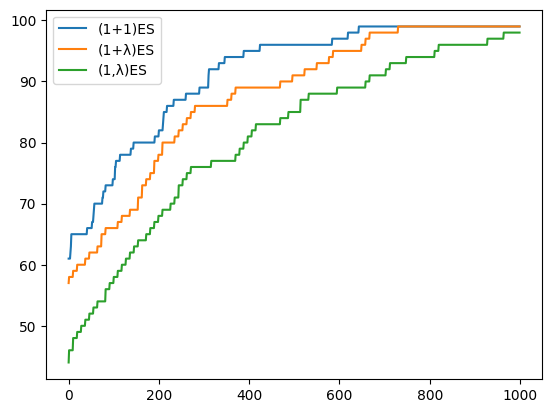

In [14]:
fitness_values = []
onecommalambda()
ocl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.legend()

We will next generalise our `one-` strategies to larger populations than just one, which represents the third parameter encoded in the name. In evolution strategies, the population size is typically denoted as μ, and we can easily generalise our (1+λ)-ES to a (μ+λ)-ES, where the μ parents produce a total of λ offspring, and then survivor selection considers all parents together with (_plus_) all their offspring.

In [15]:
mu = 3
def mupluslambda():
    population = [get_random_solution() for _ in range(mu)]
    best = max(population, key = lambda x: get_fitness(x))
    best_fitness = get_fitness(best)
    fitness_values.extend([best_fitness] * mu)
    steps = mu
    while steps < max_steps:
        candidates = [mutate(current) for current in random.choices(population, k=lmbda)]
        candidates.extend(population)
        steps += lmbda

        candidates.sort(key = lambda x: get_fitness(x), reverse = True)
        candidate = candidates[0]
        if get_fitness(candidate) > best_fitness:
            best = candidate
            best_fitness = get_fitness(best)
        population = candidates[:mu]
        fitness_values.extend([best_fitness] * lmbda)

    return best

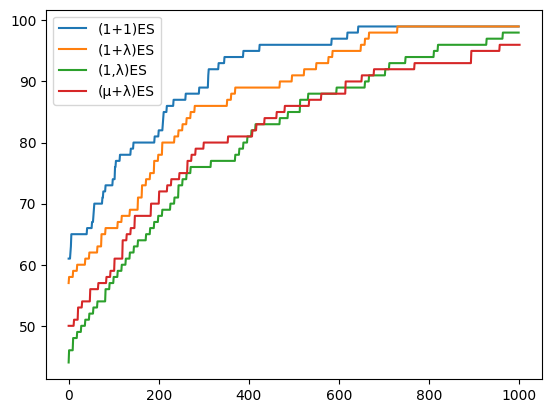

In [16]:
fitness_values = []
mupluslambda()
mpl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.legend()

While the fitness curve likely is less steep than in the former versions of the evolution strategy, note that in the plot we are only increasing once we have completed the evaluation of an entire generation.

For the sake of completeness, let's also consider the (μ,λ)-ES, where the survivor selection only considers the offspring, but not the parents. The (μ,λ)-selection is often preferred in practice because it is better at leaving local optima as well as following moving optima. Note that for (μ,λ) selection μ < λ must hold.

In [17]:
def mucommalambda():
    population = [get_random_solution() for _ in range(mu)]
    best = max(population, key = lambda x: get_fitness(x))
    best_fitness = get_fitness(best)
    fitness_values.extend([best_fitness] * mu)
    steps = mu
    while steps < max_steps:
        candidates = [mutate(current) for current in random.choices(population, k=lmbda)]
        steps += lmbda

        candidates.sort(key = lambda x: get_fitness(x), reverse = True)
        candidate = candidates[0]
        if get_fitness(candidate) > best_fitness:
            best = candidate
            best_fitness = get_fitness(best)
        population = candidates[:mu]
        fitness_values.extend([best_fitness] * lmbda)

    return best

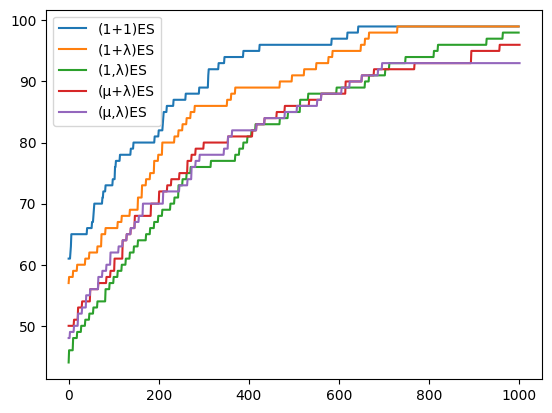

In [18]:
fitness_values = []
mucommalambda()
mcl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.plot(mcl_values, label = "(μ,λ)ES")
plt.legend()

The evolution strategies we have considered so far did not include recombination: We simply copied the parents. There is another parameter which we need to consider, and which was hidden from the name so far: The number of individuals involved in recombination ρ. So far, we had implicitly assumed ρ=1, which is known as _cloning_. The parameter is typically included in the name of the evolution strategy using the scheme (μ/ρ,λ). Let's consider the case of ρ=2:

In [19]:
rho = 2

In order to combine to parents, we need to combine two parents to one offspring. Crossover takes the genetic material of two or more parent individuals, and recombines them. A basic crossover operator is single-point crossover, where, for two parent chromosomes of length n, we pick a point 0 < x < n, and then take the first x genes from the first parent, and the remaining n - x genes from the second parent. Crossover can be implemented to return a single combined individual, or we can return both variants (and if we only need one, we can randomly choose one).

In [20]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return offspring1, offspring2

Integrating crossover (ρ=2) into our evolution strategies gives us a (μ/2+λ) algorithm:

In [21]:
def mu2pluslambda():
    population = [get_random_solution() for _ in range(mu)]
    best = max(population, key = lambda x: get_fitness(x))
    best_fitness = get_fitness(best)
    fitness_values.extend([best_fitness] * mu)
    steps = mu
    while steps < max_steps:
        candidates = []
        for x in range(lmbda):
            parents = random.choices(population, k = 2)
            child = random.choice(singlepoint_crossover(parents[0], parents[1]))
            child = mutate(child)
            candidates.append(child)
            steps += 1

        # Plus selection
        candidates.extend(population)
        candidates.sort(key = lambda x: get_fitness(x), reverse = True)
        candidate = candidates[0]
        if get_fitness(candidate) > best_fitness:
            best = candidate
            best_fitness = get_fitness(best)
        population = candidates[:mu]
        fitness_values.extend([best_fitness] * lmbda)

    return best

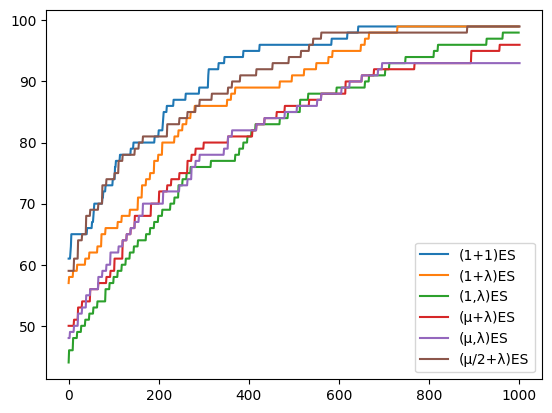

In [22]:
fitness_values = []
mu2pluslambda()
m2pl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.plot(mcl_values, label = "(μ,λ)ES")
plt.plot(m2pl_values, label = "(μ/2+λ)ES")
plt.legend()

Of course we also have a comma-selection variant:

In [23]:
def mu2commalambda():
    population = [get_random_solution() for _ in range(mu)]
    best = max(population, key=lambda x: get_fitness(x))
    best_fitness = get_fitness(best)
    fitness_values.extend([best_fitness] * mu)
    steps = mu
    while steps < max_steps:
        candidates = []
        for x in range(lmbda):
            parents = random.choices(population, k=mu)
            child = random.choice(singlepoint_crossover(parents[0], parents[1]))
            child = mutate(child)
            candidates.append(child)
            steps += 1

        # Comma selection
        candidates.sort(key=lambda x: get_fitness(x), reverse=True)
        candidate = candidates[0]
        if get_fitness(candidate) > best_fitness:
            best = candidate
            best_fitness = get_fitness(best)
        population = candidates[:mu]
        fitness_values.extend([best_fitness] * lmbda)

    return best

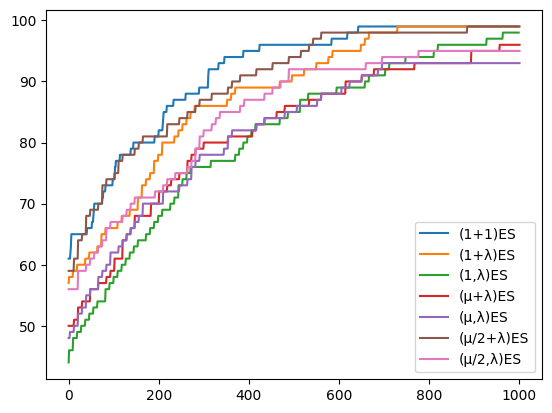

In [24]:
fitness_values = []
mu2commalambda()
m2cl_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.plot(mcl_values, label = "(μ,λ)ES")
plt.plot(m2pl_values, label = "(μ/2+λ)ES")
plt.plot(m2cl_values, label = "(μ/2,λ)ES")
plt.legend()

An important element of evolution strategies in general we haven't touched upon yet is self-adaptation -- which is a topic we will consider in a later lecture.

## Simple Genetic Algorithm

Traditionally, a main difference between evolution strategies and genetic algorithms is that evolution strategies manipulate the phenotype directly, since they were originally applied to real-valued functions. In contrast, genetic algorithms traditionally act on a genetic encoding (usually binary encoding), and the fitness is evaluated on the decoded phenotype. For our one max example, the difference is rather irrelevant, since our phenotype _is_ a bitstring.

A second major difference lies in the selection strategy: In a canonical, simple Genetic Algorithm the deterministic parent selection is usually replaced with a probabilistic selection strategy, typically applied to larger populations. As a simple first example, we will use tournament selection: For a given number of individuals (the tournament size) we randomly select individuals from the population (with or without replacement), and the best of these individuals wins the tournament, and is a parent for reproduction.

In [25]:
tournament_size = 5
def tournament_selection(population, replacement = False):
    if replacement:
        candidates = random.choices(population, k = tournament_size)
    else:
        candidates = random.sample(population, tournament_size)
        
    return max(candidates, key = lambda x: get_fitness(x))

Note: We are redundantly calculating fitness here. However, we will not count these fitness evaluations as it would be trivial to cache fitness values to avoid recalculation, but that would clutter up the examples. (We will cache fitness values in later iterations of the algorithms we are considering).

For survivor selection, there are different models: In a _generational_ genetic algorithm, an entire new offspring population is bred, and then replaces the parent population. In a _steady-state_ genetic algorithm, one offspring (or pair of offspring) is generated per generation and one member of population is replaced by that offspring. We will start with a generational genetic algorithm, but include another twist on survivor selection: In _elitism_ a certain share of the best individuals of one generation survives _unchanged_ to the next generation:

In [26]:
def elitism(population):
    population.sort(key = lambda k: get_fitness(k), reverse = True)
    return population[:elite_size]

Before we implement the genetic algorithm, there are a couple of parameters we need to decide on: How large shall the population be? How many of these shall always survive based on elitism? What should the probability for mutation be? While we have avoided the question of the mutation rate by encoding that into the mutation operator, we need to choose sensible values for all other parameters. We will use some common default values:

In [27]:
population_size = 20
elite_size = int(population_size * 0.05)
P_xover = 0.7
selection = tournament_selection
crossover = singlepoint_crossover
fitness_values = []

In [28]:
def ga():
    population = [get_random_solution() for _ in range(population_size)]

    best_fitness = -1
    steps = 0
    for p in population: # We are iterating over the population only so that our plot is more fine-grained
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness, best_solution = fitness, p[:]
        steps += 1
        fitness_values.append(best_fitness)

    while steps < max_steps:
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1, parent2 = selection(population), selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1[:], parent2[:]

            offspring1, offspring2 = mutate(offspring1), mutate(offspring2)
            new_population += [offspring1, offspring2]

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            steps += 1
            if fitness > best_fitness:
                best_fitness, best_solution = fitness, p
            fitness_values.append(best_fitness)

    return best_solution


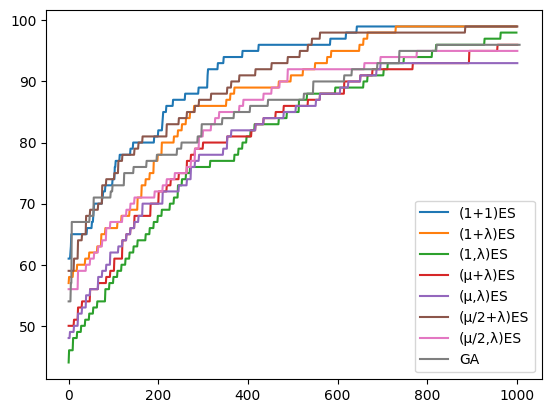

In [29]:
fitness_values = []
ga()
ga_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.plot(mcl_values, label = "(μ,λ)ES")
plt.plot(m2pl_values, label = "(μ/2+λ)ES")
plt.plot(m2cl_values, label = "(μ/2,λ)ES")
plt.plot(ga_values, label = "GA")
plt.legend()

### Steady State Genetic Algorithm

Our simple genetic algorithm uses a _generational model_, where each iteration produces a new offspring population. An alternative is a _steady state_ genetic algorithm: In each iteration, we only pick a small number of individuals (e.g., 2), produce offspring, and then replace the parents with the offspring. During this replacement we can apply differnet survivor strategies; for example, the offspring can always replace the parents, or we could always use the best out of the set of parents and their offspring.

In [30]:
def steadystatega():
    population = [get_random_solution() for _ in range(population_size)]
    steps = 0
    
    best_fitness = -1
    best = None

    for p in population:
        fitness = get_fitness(p)
        steps += 1
        if fitness > best_fitness:
            best_fitness, best = fitness, p
        fitness_values.append(best_fitness)

    while steps < max_steps:
        parent1, parent2 = selection(population), selection(population)        
        p1, p2 = population.index(parent1), population.index(parent2)

        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1[:], parent2[:]

        offspring1, offspring2 = mutate(offspring1), mutate(offspring2)
        
        best1, best2 = sorted([parent1, parent2, offspring1, offspring2], key = lambda item: get_fitness(item), reverse = True)[:2]
        population[p1] = best1
        population[p2] = best2
        steps += 2

        if get_fitness(best1) > best_fitness:
            best_fitness, best = get_fitness(best1), best1[:]

        fitness_values.append(best_fitness)
        fitness_values.append(best_fitness)

    return best


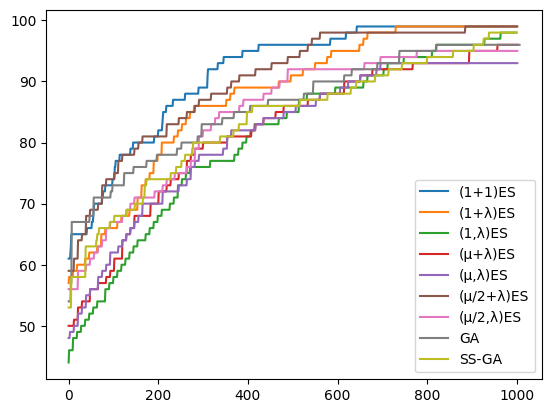

In [31]:
fitness_values = []
steadystatega()
ssga_values = fitness_values[:]
plt.plot(opo_values, label = "(1+1)ES")
plt.plot(opl_values, label = "(1+λ)ES")
plt.plot(ocl_values, label = "(1,λ)ES")
plt.plot(mpl_values, label = "(μ+λ)ES")
plt.plot(mcl_values, label = "(μ,λ)ES")
plt.plot(m2pl_values, label = "(μ/2+λ)ES")
plt.plot(m2cl_values, label = "(μ/2,λ)ES")
plt.plot(ga_values, label = "GA")
plt.plot(ssga_values, label = "SS-GA")
plt.legend()

## Comparison of the algorithms

We defined a rather large space of possible algorithms and variations, and the usual question is: Which of these works best? We already saw some trends emerging from the plots above, for example the (1+1)ES tends to do well. Let's evaluate some variants in more detail.

To simplify experiments, we will define a helper function that runs an algorithm for a number of repetitions and gives us a list of resulting fitness values.

In [32]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values
    result = []
    for i in range(repetitions):
        fitness_values = []
        with io.capture_output() as captured: 
            algorithm()
        result.append(fitness_values[-1])
    return result

Now we have to call this for each of the algorithms

In [33]:
crossover = singlepoint_crossover
selection = tournament_selection
max_steps = 1000

results = {"GA"      : run_times(ga, 30), 
           "SS-GA"   : run_times(steadystatega, 30),
           "(μ/2+λ)ES" : run_times(mu2pluslambda, 30),
           "(μ/2,λ)ES" : run_times(mu2commalambda, 30),
           "(μ+λ)ES" : run_times(mupluslambda, 30),
           "(μ,λ)ES" : run_times(mucommalambda, 30),
           "(1+1)ES" : run_times(oneplusone, 30), }

We can compare the results by plotting the distributions of the final fitness values:

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)ES'),
 Text(4, 0, '(μ/2,λ)ES'),
 Text(5, 0, '(μ+λ)ES'),
 Text(6, 0, '(μ,λ)ES'),
 Text(7, 0, '(1+1)ES')]

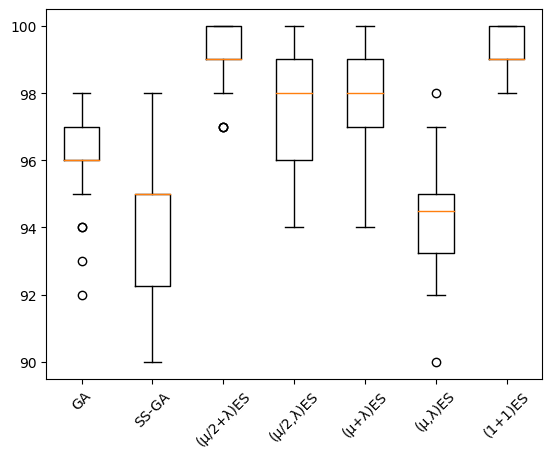

In [34]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

If we want to know whether there is a statistical difference between two configurations, we can use the statistics we learned in the previous chapter, e.g. a Mann-Whitney U test to compare (1+1)ES with (μ/2+λ)ES:

In [35]:
from scipy.stats import mannwhitneyu
result = mannwhitneyu(results["(μ/2+λ)ES"], results["(1+1)ES"])
result[1]

0.42700758863957244

Most likely, the results suggest that (1+1)ES finds the solution for one max more efficiently (but whether it does so significantly we would have to test for using statistical tests and effect size measures). We only looked at one particular configuration of search operators for the GA, and varying the parameters and operators may lead to entirely different results. We will look at other operators in a later chapter. 

In the previous chapter we considered local search algorithms, which appeared to work quite well on the one-max problem. Let's see how they compare against our new global search algorithms.

All local search algorithms required a definition of neighbourhood:

In [36]:
def get_neighbours(candidate):
    neighbours = []
    for pos in range(len(candidate)):
        copy = candidate[:]
        copy[pos] = 1 - copy[pos]
        neighbours.append(copy)
    return neighbours

We'll use a first ascent hillclimber with restarts:

In [37]:
def hillclimbing():

    current = get_random_solution()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness

    step = 0
    while step < max_steps:

        replaced = False
        for neighbour in get_neighbours(current):
            neighbour_fitness = get_fitness(neighbour)
            step += 1
            if neighbour_fitness > fitness:
                current = neighbour
                fitness = neighbour_fitness
                replaced = True
                if fitness > best_fitness:
                    best = current[:]
                    best_fitness = fitness

                fitness_values.append(best_fitness)
                break
            else:
                fitness_values.append(best_fitness)

        # Random restart if no neighbour is better
        if not replaced:
            current = get_random_solution()
            fitness = get_fitness(current)
            step += 1
            if fitness > best_fitness:
                best = current[:]
                best_fitness = fitness
            fitness_values.append(best_fitness)

    return best

The second local search algorithm was tabu search:

In [38]:
tabu_size = 500
def tabusearch():
    current = get_random_solution()
    fitness = get_fitness(current)

    tabu = [current]

    best_solution = current
    best_fitness = fitness

    iteration = 0
    step = 0
    while step < max_steps:
        best_neighbour = None

        neighbour_fitness = 0
        for neighbour in get_neighbours(current):
            if neighbour not in tabu:
                new_fitness = get_fitness(neighbour)
                step += 1
                if new_fitness > neighbour_fitness:
                    best_neighbour = neighbour
                    neighbour_fitness = new_fitness
                    if neighbour_fitness > best_fitness:
                        best_fitness = neighbour_fitness
                        best_solution = best_neighbour
                fitness_values.append(best_fitness)
                

        # Append at the end of the tabu list
        tabu.append(best_neighbour)
        current = best_neighbour
        
        # Remove elements from the front of the tabu list
        while len(tabu) > tabu_size:
            tabu.pop(0)
        
        iteration += 1

    return best_solution

Finally, there is simulated annealing and its helper functions:

In [39]:
import math
def acceptance_probability(fitness, new_fitness, temperature):
    if new_fitness > fitness:
        return 1
    else:
        p = math.exp( (new_fitness - fitness) / temperature)
        return p

In [40]:
def temperature(fraction):
    return max(0.01, min(1, 1 - fraction))

In [41]:
def simulatedannealing():
    current = get_random_solution()
    fitness = get_fitness(current)

    best_solution = current
    best_fitness = fitness

    step = 0
    while step < max_steps:
        fraction = step / float(max_steps)
        T = temperature(fraction)

        neighbour = random.choice(get_neighbours(current))
        neighbour_fitness = get_fitness(neighbour)
        step += 1

        if acceptance_probability(fitness, neighbour_fitness, T) > random.random():
            current, fitness = neighbour, neighbour_fitness

            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = current
        fitness_values.append(best_fitness)

    return best_solution

We already have the results of our experiment stored in `results`, so we just need to extend our data with some runs of these three local search algorithms.

In [42]:
results.update({
    "HC"      : run_times(hillclimbing, 30),
    "Tabu"    : run_times(tabusearch, 30),
    "SA"      : run_times(simulatedannealing, 30),
})

Finally, we are ready to compare local search with our global search algorithms.

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)ES'),
 Text(4, 0, '(μ/2,λ)ES'),
 Text(5, 0, '(μ+λ)ES'),
 Text(6, 0, '(μ,λ)ES'),
 Text(7, 0, '(1+1)ES'),
 Text(8, 0, 'HC'),
 Text(9, 0, 'Tabu'),
 Text(10, 0, 'SA')]

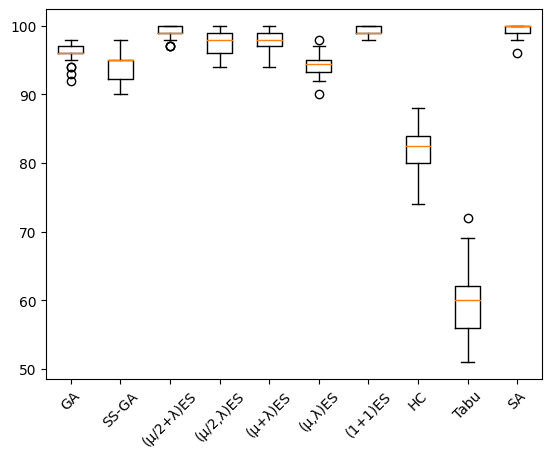

In [43]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

This result is of course specific to the particular value of `n` and the chosen number of steps for the algorithm, but does it reflect what you expected?

## Leading Ones

Let's consider an alternative problem, based on the identical representation and search operators, but with a slightly different fitness function. The Leading Ones problem is a variation of the One Max problem, and often used to study search algorithms. The fitness function for Leading Ones represents the number of leading ones in an individual:

In [44]:
def get_fitness(solution):
    fitness = 0
    for i in solution:
        if i == 1:
            fitness += 1
        else:
            break
    return fitness

In [45]:
get_fitness([1,1,1,0,0,0,0,0])

3

In [46]:
get_fitness([1,0,0,1,1,1,1,1])

1

The fitness value can always be increased by appending a single one to the leading
ones, therefore like One Max this is a _unimodal_ problem, i.e., there is only a single local optimum.

Since the fitness function is the only thing that changes, we can immediately run some new experiments to compare our search algorithms:

In [47]:
crossover = singlepoint_crossover
selection = tournament_selection
max_steps = 1000

results = {"GA"      : run_times(ga, 30), 
           "SS-GA"   : run_times(steadystatega, 30),
           "(μ/2+λ)ES" : run_times(mu2pluslambda, 30),
           "(μ/2,λ)ES" : run_times(mu2commalambda, 30),
           "(μ+λ)ES" : run_times(mupluslambda, 30),
           "(μ,λ)ES" : run_times(mucommalambda, 30),
           "(1+1)ES" : run_times(oneplusone, 30),
           "HC"      : run_times(hillclimbing, 30),
           "Tabu"    : run_times(tabusearch, 30),
           "SA"      : run_times(simulatedannealing, 30),
          }

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)ES'),
 Text(4, 0, '(μ/2,λ)ES'),
 Text(5, 0, '(μ+λ)ES'),
 Text(6, 0, '(μ,λ)ES'),
 Text(7, 0, '(1+1)ES'),
 Text(8, 0, 'HC'),
 Text(9, 0, 'Tabu'),
 Text(10, 0, 'SA')]

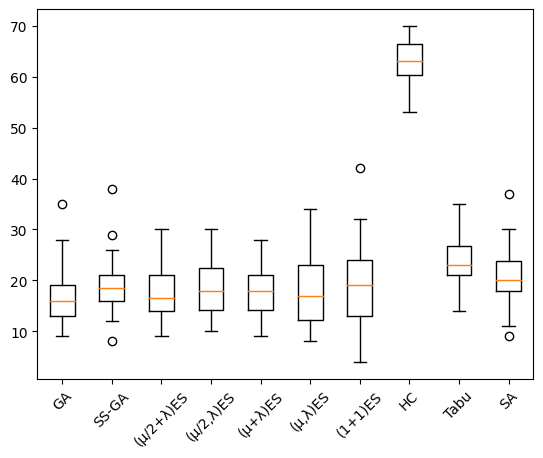

In [48]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

These results are likely somewhat different from the ones on the one max problem. In particular, the global search algorithms will perform many mutations that show no difference in the resulting fitness values -- fitness can only be improved by mutating the first `0` in the list. There is always such a neighbour that a hill climber can find, while global search algorithms are largely 'blind'.

## Evolutionary Search on the n-queens problem

As alternative example problem, we will consider the n-queens problem again, which you already know from the previous chapter:

In [49]:
def get_random_solution():
    return [random.randint(0, n-1) for _ in range(n)]

To keep the runtimes of the algorithms small, we should reduce the value of `n` compared to what we used for one max:

In [50]:
n = 20

The fitness calculation still considers the number of pairs of queens that do not check each other:

In [51]:
def get_fitness(solution):
    fitness = 0
    for i in range(len(solution) - 1):
        for j in range(i + 1, len(solution)):
            if solution[i] != solution[j] \
                and solution[i] != solution[j] + (j - i) \
                and solution[j] != solution[i] + (j - i):
                fitness += 1

    return fitness

In order to apply search to a different problem, we also need to make sure that the search operators match the problem encoding. Selection operators are independent of the representation, so we only need to worry about variation operators here. For crossover, we are just cutting and merging lists, so the single-point crossover operator we defined is just fine for the n-queens problem. We will have to change our mutation operator, however, since for one max that simply consists of flipping bits. As a basic mutation operator, we can simply probabilistically replace individual genes with new random values:

In [52]:
def mutate(individual):
    P_mutate = 1/len(individual)
    copy = individual[:]
    for position in range(len(individual)):
        if random.random() < P_mutate:
            copy[position] = random.randint(0, n-1)
    return copy

We will also need to redefine the local neighbourhood to make the local search algorithms work. (In a future revision of this notebook I'll just import them, but for now they are cloned below).

In [53]:
def get_neighbours(solution):
    neighbours = []
    for i in range(len(solution)):
        if solution[i] > 0:
            copy = solution[:]
            copy[i] = copy[i] - 1
            neighbours.append(copy)
        if solution[i] < n - 1:
            copy = solution[:]
            copy[i] = copy[i] + 1
            neighbours.append(copy)

    return neighbours

Now we can run some experiments using all the different search algorithms defined so far:

In [54]:
max_steps = 1000
tabu_size = 500

results = {"GA"        : run_times(ga, 30), 
           "SS-GA"     : run_times(steadystatega, 30),
           "(μ/2+λ)ES" : run_times(mu2pluslambda, 30),
           "(μ/2,λ)ES" : run_times(mu2commalambda, 30),
           "(μ+λ)ES"   : run_times(mupluslambda, 30),
           "(μ,λ)ES"   : run_times(mucommalambda, 30),
           "(1+1)ES"   : run_times(oneplusone, 30), 
           "HC"        : run_times(hillclimbing, 30),
           "Tabu"      : run_times(tabusearch, 30),
           "SA"        : run_times(simulatedannealing, 30)
          }

[Text(1, 0, 'GA'),
 Text(2, 0, 'SS-GA'),
 Text(3, 0, '(μ/2+λ)ES'),
 Text(4, 0, '(μ/2,λ)ES'),
 Text(5, 0, '(μ+λ)ES'),
 Text(6, 0, '(μ,λ)ES'),
 Text(7, 0, '(1+1)ES'),
 Text(8, 0, 'HC'),
 Text(9, 0, 'Tabu'),
 Text(10, 0, 'SA')]

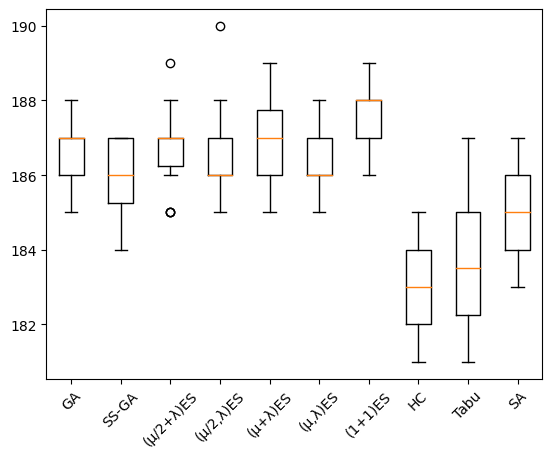

In [55]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys(), rotation=45)

At this point, we could also dig into more statistics on the comparisons. But did we really choose the right operators and parameters? This is a question for a future chapter.

## Outlook

In this chapter, we considered some basic variation and selection operators. In the next chapter we will consider a couple of alternatives. Besides all the possible variations in parameters and search operators, there are also many variations of the algorithms themselves. Some specific variants we will consider in later lectures in this course are the following:

- Parallel GAs, in which independent island populations are evolved and sporadically exchange individuals
- Cellular GAs, in which a topology is imposed on the population, and decides on candidates for reproduction
- Memetic Algorithms, which extend GAs with local search
- Adaptive GAs, in which the parameters evolve together with the solutions.

Besides these fundamental variations of the canonical GA, each variant further has many different options. What population size to use? Which selection operator? Which replacement operator? What probabilities to apply the different variation operators? We will consider in a future lecture how to choose these parameters.
